<a href="https://colab.research.google.com/github/umeshasewwandi39/project-01/blob/main/GWAS_SNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/preprocessed_gwas_snps-2.csv'  # adjust if inside a folder
df = pd.read_csv(file_path)

df.head()

,chr,position,rsid,p_value,log_p,genomic_position
0,1,752566,rs3094315,0.701473,0.153989,chr1:752566
1,1,768448,rs12562034,0.214345,0.668886,chr1:768448
2,1,779322,rs4040617,0.325549,0.487383,chr1:779322
3,1,785989,rs2980300,0.109823,0.959305,chr1:785989
4,1,1003629,rs4075116,0.572713,0.242063,chr1:1003629


### Classic ML Models: Random Forest & XGBoost (Using log_p)

In [3]:
# Create label: 1 if p-value < 5e-8 (significant SNP), else 0
df['label'] = (df['p_value'] < 5e-8).astype(int)

# Features (using only log_p for now)
features = ['log_p']
X = df[features]
y = df['label']

In [4]:
#split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_rf))

Random Forest AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9636
           1       1.00      1.00      1.00        13

    accuracy                           1.00      9649
   macro avg       1.00      1.00      1.00      9649
weighted avg       1.00      1.00      1.00      9649



In [6]:
#XG boost
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_xgb))

XGBoost AUC: 0.9988065587380656
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9636
           1       0.00      0.00      0.00        13

    accuracy                           1.00      9649
   macro avg       0.50      0.50      0.50      9649
weighted avg       1.00      1.00      1.00      9649



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

Deep Learning Model: CNN on log_p

In [7]:
#Deep Learning - CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

# Reshape input for CNN
X_train_cnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(-1, X_test.shape[1], 1)

model = Sequential([
    Conv1D(16, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9982 - auc: 0.0556 - loss: 0.2041 - val_accuracy: 0.9992 - val_auc: 1.0000 - val_loss: 0.0042
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9993 - auc: 0.9418 - loss: 0.0047 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.4440e-04
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9998 - auc: 0.9805 - loss: 0.0012 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.3238e-04
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9998 - auc: 0.9727 - loss: 9.3460e-04 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.7132e-04
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9999 - auc: 0.9925 - loss: 4.2179e-04 - val_accuracy: 0.9997 - val_auc: 1.0000 - val_loss: 3.5709e-04
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9998 - auc: 0.9941 - loss: 6.3160e-04 - val_accuracy: 0.9999 - val_auc: 1.0000 - val_loss: 2.3706e-04
Epoch 7

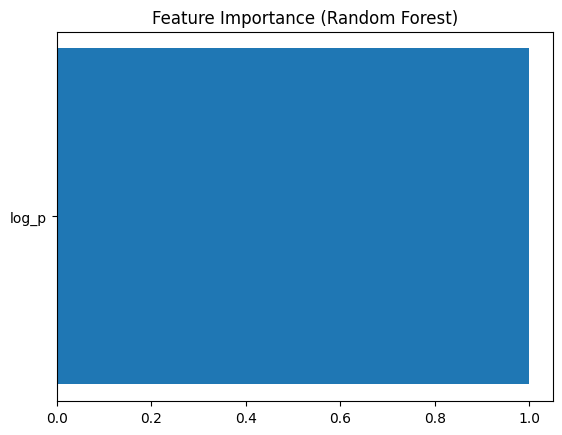

In [10]:
import matplotlib.pyplot as plt

plt.barh(features, rf.feature_importances_)
plt.title("Feature Importance (Random Forest)")
plt.show()